# **Jesus Gerardo Galaz Montoya**
# **Email Address:** jgalaz@gmail.com
# **PROJECT:** IMDB chatbot

# **1. Data Collection and Preprocessing**

# 1.0 If using Google Drive, mount it to use it for logging and chat history between sessions below

In [27]:
import os

# 1) Mount Drive and create the movie_bot directory

# If running on Google colab:
#from google.colab import drive
#drive.mount('/content/drive')
#MOVIE_BOT_DIR = '/content/drive/My Drive/movie_bot'

# If running locally:
MOVIE_BOT_DIR = '/Users/jgalaz/Dropbox/scripts/ml_misc_projects/case_study_2_imdb_ml/movie_bot'
os.makedirs(MOVIE_BOT_DIR, exist_ok=True)

# 2) Point the log file to be inside MOVIE_BOT_DIR
LOG_PATH = os.path.join(MOVIE_BOT_DIR, 'chat_history.json')


# 1.1 Load OPENAI_API_KEY

In [28]:
import os

# Make sure that OPENAI_API_KEY exist as an environment variable in ~/.openai_env
# and access it through a settings file; e.g., in Visual Studio code, you can make an invisible
# subdirectory in the project directory, with .json file in it: .vscode/settings.json
# The settings.json file would then contain: 
#{
#  "python.envFile": "/Users/jgalaz/.openai_env",
#  "jupyter.envFile": "/Users/jgalaz/.openai_env"
#}

api_key = os.environ.get("OPENAI_API_KEY")

if not api_key:
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENAI_API_KEY')
    except Exception:
        pass

if not api_key:
    raise RuntimeError("No OpenAI API key found")

os.environ["OPENAI_API_KEY"] = api_key

# Optionally pass it explicitly to the client:
# client = OpenAI(api_key=api_key)

print("Loaded OpenAI API key from environment.")


Loaded OpenAI API key from environment.


# 1.2 Test OpenAI API

In [29]:
# Importing the OpenAI library to interact with OpenAI's API services.
from openai import OpenAI
client = OpenAI(api_key=api_key)

response = client.responses.create(
    model="gpt-4.1",
    input="Test'"
)

print(response.output_text)

# Import basic libraries
import pandas as pd
import numpy as np

Hello! It looks like you wrote "Test." How can I assist you today?


# 1.3 Load the IMDB dataset

In [30]:
# Load the data
#file_path = '/content/sample_data/IMDb_Dataset.csv'
file_path = '/Users/jgalaz/Dropbox/scripts/ml_misc_projects/case_study_2_imdb_ml/IMDb_Dataset.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("File found and loaded successfully.")
else:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is uploaded to the correct location.")


File found and loaded successfully.


# 1.4 Initial examination of the dataset for completeness and repeats

In [31]:
# View & Understand the data
print(f"The shape of the data frame is {df.shape}.")
print(f"Meaning there are {len(df)} movie records and {len(df.columns)} data fields for each.\n")
df.info()
print("\n")
df.describe()

# Since .info() revealed there are no null values, we don't need the
# commented out code below, but it could have been useful if we had encountered
# nulls:

#missing_per_column = df.isnull().sum()
#print("\nMissing values per column:\n", missing_per_column)
# Percentage of missing values per column
#percent_missing = (missing_per_column / len(df)) * 100
#print("\nPercentage of missing values per column:\n", percent_missing)
# Count complete vs incomplete rows
#complete_rows = df.dropna().shape[0]
#incomplete_rows = len(df) - complete_rows
#print(f"\nComplete records: {complete_rows}")
#print(f"Incomplete records: {incomplete_rows}")

# The data seem to be complete, but although .info() checks for non-nullity,
# it does not detect empty strings (""), "N/A", "Unknown", or "None" stored as text.
# It also does not detect placeholder values like 0, so let's check for these.

# Check for empty or placeholder values that are not technically null
for col in df.columns:
    print(f"\n Unique values in '{col}':\n", len(df[col].unique()))

print("\n")
# Check for empty strings specifically
for col in df.select_dtypes(include=['object']).columns:
    empty_count = (df[col].str.strip() == '').sum()
    print(f"Empty strings in {col}: {empty_count}")

print("\n")

# Check how many unique titles there are
unique_titles = df['Title'].nunique()
total_titles = len(df)
print(f"Unique Titles: {unique_titles} / Total Records: {total_titles}")

# Count duplicates
duplicate_titles = df['Title'][df['Title'].duplicated(keep=False)]
print(duplicate_titles.value_counts())

# Count fully duplicated records (indetical rows; excluding the first occurrence)
duplicate_count = df.duplicated().sum()
print(f"\nNumber of fully duplicated records: {duplicate_count}")

# View the first fiew elements explicitly
df.head()



The shape of the data frame is (3173, 10).
Meaning there are 3173 movie records and 10 data fields for each.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               3173 non-null   object 
 1   IMDb Rating         3173 non-null   float64
 2   Year                3173 non-null   int64  
 3   Certificates        3173 non-null   object 
 4   Genre               3173 non-null   object 
 5   Director            3173 non-null   object 
 6   Star Cast           3173 non-null   object 
 7   MetaScore           3173 non-null   float64
 8   Poster-src          3173 non-null   object 
 9   Duration (minutes)  3173 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 248.0+ KB



 Unique values in 'Title':
 2739

 Unique values in 'IMDb Rating':
 48

 Unique values in 'Year':
 93

 Unique values in 'Certif

,Title,IMDb Rating,Year,Certificates,Genre,Director,Star Cast,MetaScore,Poster-src,Duration (minutes)
0,End of the Spear,6.8,2005,PG-13,Adventure,Jim Hanon,Louie LeonardoChad AllenJack Guzman,45.0,https://m.media-amazon.com/images/M/MV5BMTYxOT...,108.0
1,Elvira Madigan,7.0,1967,PG,Biography,Bo Widerberg,Pia DegermarkThommy BerggrenLennart Malmer,66.0,https://m.media-amazon.com/images/M/MV5BMmY2Nj...,91.0
2,The Kid Stays in the Picture,7.3,2002,R,Documentary,Nanette Burstein,Robert EvansEddie AlbertPeter Bart,75.0,https://m.media-amazon.com/images/M/MV5BZjhiZm...,93.0
3,It Ain't Over,8.2,2022,PG,Documentary,Sean Mullin,Andy AndresRoger AngellMarty Appel,79.0,https://m.media-amazon.com/images/M/MV5BZWViYW...,99.0
4,Mahler,7.0,1974,PG,Biography,Ken Russell,Robert PowellGeorgina HaleLee Montague,66.0,https://m.media-amazon.com/images/M/MV5BYzY4Mz...,115.0


## 1.4.1 ANALYSIS

### 1.   There are 3173 records, but only 2739 unique titles, suggesting 434 repeats (~14% duplicates).
### 2.   There are 411 fully duplicated (redundant) rows.
### 3.   There are 2592 unique Star Cast for 2739 unique Titles, suggesting that different Titles share the same Star Cast, which may be suspicious.



# 1.5 Clean up aberrant fields

## 1.5.1 Drop identical rows

In [32]:
# From the examination above, there seem to be 411 redundant (unnecessary) entries
# Thus, I'll remove them.

# Report before cleanup
print(f"Total records before deduplication: {len(df)}")

# Drop fully identical rows (entire rows, but keep one copy)
df = df.drop_duplicates(keep="first")

# Report after cleanup
print(f"\nTotal records after deduplication: {len(df)}")

# Check for unique values after deduplication (should be the same as before)
for col in df.columns:
    print(f"\n Unique values in '{col}':\n", len(df[col].unique()))


Total records before deduplication: 3173

Total records after deduplication: 2762

 Unique values in 'Title':
 2739

 Unique values in 'IMDb Rating':
 48

 Unique values in 'Year':
 93

 Unique values in 'Certificates':
 16

 Unique values in 'Genre':
 17

 Unique values in 'Director':
 2089

 Unique values in 'Star Cast':
 2592

 Unique values in 'MetaScore':
 78

 Unique values in 'Poster-src':
 2623

 Unique values in 'Duration (minutes)':
 156


## 1.5.2 Fix problem of multiple Titles with the same Star Cast. This is legitimate for sequels, but it is not clear that this is correct for other cases where the same Star Cast is assigned to multiple movies.

---



In [33]:
# I'll examine the most common Director and Cast, to see what's going on with the Cast and Title mismatch

# I'll make a function for this because I know there are problems and I'll need to regenerate
# this table after fixing them to confirm they've been fixed
def plot_directors_and_actors_table(df):

  # Process Actors
  from itertools import chain
  actors = df['Star Cast'].dropna().apply(lambda x: [actor.strip() for actor in x.split(',')])
  actors_flat = list(chain.from_iterable(actors))
  top_actors_series = pd.Series(actors_flat).value_counts().head(10)

  # Build a clean DataFrame
  summary_table = pd.DataFrame({
      'Top Directors': df['Director'].value_counts().head(10).index,
      'Director Count': df['Director'].value_counts().head(10).values,
      'Top Actors': top_actors_series.index,
      'Actor Count': top_actors_series.values
  })

  print('\n')

  # Display
  from IPython.display import display
  display(summary_table)

plot_directors_and_actors_table(df)

dr=0
ew=0
rg=0
for index,row in df.iterrows():
  if 'Daniel Radcliffe' in row['Star Cast']:
      dr+=1
  if 'Emma Watson' in row['Star Cast']:
      ew+=1
  if 'Rupert Grint' in row['Star Cast']:
      rg+=1

print(f"Daniel Radcliffe appears in {dr} movies")
print(f"Emma Watson appears in {ew} movies")
print(f"Rupert Grint appears in {rg} movies")

,Top Directors,Director Count,Top Actors,Actor Count
0,Ridley Scott,19,Daniel RadcliffeEmma WatsonRupert Grint,140
1,Steven Spielberg,14,J.R.R. TolkienFran WalshPhilippa Boyens,3
2,Martin Scorsese,11,Yoshiyuki Tomino,3
3,Clint Eastwood,10,Lucas HeppeRyan E. HeppeAndrew Hicks,3
4,Tim Burton,9,Hayao Miyazaki,3
5,Oliver Stone,9,Esses TamásVéber ZoltánTokodi Sandor,2
6,Ron Howard,8,Alan Bennett,2
7,Christopher Nolan,8,Hyung-rae ShimEun-kyeong JeonKim Su-Mi,2
8,David Fincher,7,Thomas BaierUdo BurmeisterHansjuergen Hespos,2
9,George Miller,7,Kevin ChristensenAnthony ParisiJoshua Sikora,2


Daniel Radcliffe appears in 144 movies
Emma Watson appears in 142 movies
Rupert Grint appears in 141 movies


#### 1.5.2.1 Daniel Radcliffe, Emma Watson, and Rupert Grint appear in 140 movies; this is obviously wrong, and needs to be remedied.

In [34]:
# Group by Star Cast and aggregate their Titles
cast_to_titles = df.groupby('Star Cast')['Title'].unique()

# Filter by casts linked to more than one unique title
ambiguous_casts = cast_to_titles[cast_to_titles.apply(len) > 1]

# Convert to a DataFrame for easier viewing
ambiguous_casts_df = ambiguous_casts.reset_index().rename(columns={'Star Cast': 'Cast', 'Title': 'Titles'})

# Expand titles to comma-separated strings for display
ambiguous_casts_df['Titles'] = ambiguous_casts_df['Titles'].apply(lambda x: ', '.join(x))

# Preview the table
from IPython.display import display
#display(ambiguous_casts_df.head(5))  # Show top 5 cases

# I'll define a function to validate Daniel Radcliffe, Emma Watson, and Rupert Grint
# are only listed in the cast for "Harry Potter" series movies in the Title field
# since they are not known to appear together in any other movie; otherwise, the Star Cast
# will be labelled as "not verified"

def clean_hp_cast(row):
    if ('Daniel Radcliffe' in row['Star Cast']
        and 'Emma Watson' in row['Star Cast']
        and 'Rupert Grint' in row['Star Cast']
        and 'harry potter' not in row['Title'].lower()):
        return ''  # Clear invalid cast
    return row['Star Cast']

# Apply the cleaning function
df['Star Cast'] = df.apply(clean_hp_cast, axis=1)

# Impute cleared casts
df['Star Cast'] = df['Star Cast'].replace('', 'Cast not verified')

'''
# Top 10 Directors
top_directors = df['Director'].value_counts().head(10)

# Process Actors
from itertools import chain
actors = df['Star Cast'].dropna().apply(lambda x: [actor.strip() for actor in x.split(',')])
actors_flat = list(chain.from_iterable(actors))
top_actors_series = pd.Series(actors_flat).value_counts().head(10)

# Build a clean DataFrame
summary_table = pd.DataFrame({
    'Top Directors': df['Director'].value_counts().head(10).index,
    'Director Count': df['Director'].value_counts().head(10).values,
    'Top Actors': top_actors_series.index,
    'Actor Count': top_actors_series.values
})

print('\n')

# Display
from IPython.display import display
display(summary_table)
'''

plot_directors_and_actors_table(df)

,Top Directors,Director Count,Top Actors,Actor Count
0,Ridley Scott,19,Cast not verified,134
1,Steven Spielberg,14,Daniel RadcliffeEmma WatsonRupert Grint,6
2,Martin Scorsese,11,J.R.R. TolkienFran WalshPhilippa Boyens,3
3,Clint Eastwood,10,Yoshiyuki Tomino,3
4,Tim Burton,9,Lucas HeppeRyan E. HeppeAndrew Hicks,3
5,Oliver Stone,9,Hayao Miyazaki,3
6,Ron Howard,8,Esses TamásVéber ZoltánTokodi Sandor,2
7,Christopher Nolan,8,Alan Bennett,2
8,David Fincher,7,Hyung-rae ShimEun-kyeong JeonKim Su-Mi,2
9,George Miller,7,Thomas BaierUdo BurmeisterHansjuergen Hespos,2


### 1.5.3 The Star Cast names are merged without a space or comma in between; fix formatting of Start Cast column entries

In [35]:
# The actors list seems to be improperly formatted,
# with last names merging into the first name of the next actor
print(df['Star Cast'].head(10).tolist())

import re

def fix_actor_list(actor_str):
    # Insert ", " between lowercase-uppercase transitions
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ', ', actor_str)

# Apply the fix to the column
df['Star Cast'] = df['Star Cast'].apply(fix_actor_list)

# Inspect results
print(df['Star Cast'].head(10).tolist())

['Louie LeonardoChad AllenJack Guzman', 'Pia DegermarkThommy BerggrenLennart Malmer', 'Robert EvansEddie AlbertPeter Bart', 'Andy AndresRoger AngellMarty Appel', 'Robert PowellGeorgina HaleLee Montague', 'Cliff CurtisJames RollestonKirk Torrance', 'Stephen CurryBob McKillopJason Richards', 'Emma ThompsonJonathan PryceSteven Waddington', 'Garrett HedlundAndrea RiseboroughForest Whitaker', 'Christoph WaltzVanessa RedgraveAnnette Bening']
['Louie Leonardo, Chad Allen, Jack Guzman', 'Pia Degermark, Thommy Berggren, Lennart Malmer', 'Robert Evans, Eddie Albert, Peter Bart', 'Andy Andres, Roger Angell, Marty Appel', 'Robert Powell, Georgina Hale, Lee Montague', 'Cliff Curtis, James Rolleston, Kirk Torrance', 'Stephen Curry, Bob Mc, Killop, Jason Richards', 'Emma Thompson, Jonathan Pryce, Steven Waddington', 'Garrett Hedlund, Andrea Riseborough, Forest Whitaker', 'Christoph Waltz, Vanessa Redgrave, Annette Bening']


### 1.5.4 Verify that the problem with Harry Potter cast being overrepresented has been fixed

In [36]:
# List of actors to inspect
actors_to_check = ['Daniel Radcliffe', 'Emma Watson', 'Rupert Grint']

# Function to list titles per actor
for actor in actors_to_check:
    print(f"\nTitles featuring {actor}:")
    matching_titles = df[df['Star Cast'].str.contains(actor, case=False, na=False)]['Title'].unique()
    print(f"({len(matching_titles)} titles)")
    print("\n".join(matching_titles))

for actor in actors_to_check:
    print(f"\nRow appearances for {actor}:")
    count = df[df['Star Cast'].str.contains(actor, case=False, na=False)].shape[0]
    print(count)


Titles featuring Daniel Radcliffe:
(10 titles)
Imperium
Jungle
Harry Potter and the Half-Blood Prince
Harry Potter and the Order of the Phoenix
Harry Potter and the Deathly Hallows: Part 1
Harry Potter and the Chamber of Secrets
Harry Potter and the Deathly Hallows: Part 2
Harry Potter and the Prisoner of Azkaban
Harry Potter and the Goblet of Fire
Horns

Titles featuring Emma Watson:
(8 titles)
Colonia
Harry Potter and the Half-Blood Prince
Harry Potter and the Order of the Phoenix
Harry Potter and the Deathly Hallows: Part 1
Harry Potter and the Chamber of Secrets
Harry Potter and the Deathly Hallows: Part 2
Harry Potter and the Prisoner of Azkaban
Harry Potter and the Goblet of Fire

Titles featuring Rupert Grint:
(7 titles)
Harry Potter and the Half-Blood Prince
Harry Potter and the Order of the Phoenix
Harry Potter and the Deathly Hallows: Part 1
Harry Potter and the Chamber of Secrets
Harry Potter and the Deathly Hallows: Part 2
Harry Potter and the Prisoner of Azkaban
Harry Pot

### Verify actors and directors table again after fixing name merger formatting aberration

In [37]:
plot_directors_and_actors_table(df)

,Top Directors,Director Count,Top Actors,Actor Count
0,Ridley Scott,19,Cast not verified,134
1,Steven Spielberg,14,Tom Hanks,13
2,Martin Scorsese,11,Yoshiyuki Tomino,12
3,Clint Eastwood,10,Caprio,11
4,Tim Burton,9,Leonardo Di,11
5,Oliver Stone,9,Anthony Hopkins,11
6,Ron Howard,8,Daniel Radcliffe,10
7,Christopher Nolan,8,Matt Damon,10
8,David Fincher,7,Woody Harrelson,10
9,George Miller,7,Johnny Depp,9


# **2. Perform Exploratory Data Analysis**

## (EDA; e.g., frequency of terms in titles, actors, directors, distribution of genres, ratings, years, length, etc.)

## 2.1 EDA 1: Tokenize titles and analyze keyword frequency

The top-20 most common words are: [('the', 874), ('of', 305), ('a', 106), ('in', 87), ('and', 87), ('s', 79), ('man', 43), ('to', 43), ('i', 32), ('last', 30), ('for', 30), ('on', 30), ('story', 27), ('black', 23), ('love', 21), ('world', 21), ('from', 21), ('with', 21), ('american', 21), ('la', 21)]

The top-20 most common MEANINGFUL words are: [('man', 43), ('last', 30), ('story', 27), ('black', 23), ('love', 21), ('world', 21), ('american', 21), ('king', 20), ('war', 20), ('one', 18), ('legend', 18), ('city', 18), ('time', 18), ('movie', 17), ('day', 16), ('new', 15), ('dark', 14), ('life', 14), ('space', 14), ('red', 13)]



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jgalaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/w5/tx08gb4x0rs_qxhvcgngjb4h0000gn/T/ipykernel_97113/942800986.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x='Count', y='Word', palette='viridis')


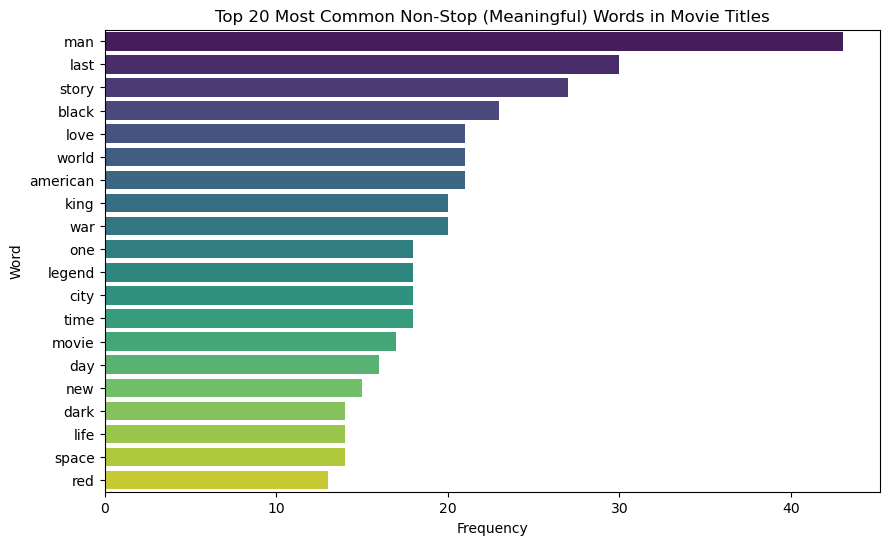

In [38]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Downloaded the "stopwords" set from nltk so that we can skip irrelevant words
# when counting, such as articles, prepositions, conjuctions, pronouns, etc.
nltk.download('stopwords')

# Define English and Spanish stop words
stop_words_english = set(stopwords.words('english'))
stop_words_spanish = set(stopwords.words('spanish'))

# Tokenize titles into words, lowercased, removing non-alphabetic characters
# Prepare containers
all_words = []
meaningful_words = []
processed_titles = []

# Process each title and capture cleaned results
for title in df['Title'].dropna():
    # Tokenize and lowercase
    words = re.findall(r'\b[a-zA-Z]+\b', title.lower())
    all_words.extend(words)

    # Filter stopwords (both languages)
    filtered_words = [word for word in words if word not in stop_words_english and word not in stop_words_spanish]
    meaningful_words.extend(filtered_words)

    # Join filtered words back into a cleaned string
    processed_title = ' '.join(filtered_words)
    processed_titles.append(processed_title)

# Align processed_titles with the DataFrame indices that had non-null Titles
df.loc[df['Title'].notna(), 'Processed Title'] = processed_titles

word_counts = Counter(all_words)
meaningful_word_counts = Counter(meaningful_words)
print(f"The top-20 most common words are: {word_counts.most_common(20)}\n")  # Top 20 words
print(f"The top-20 most common MEANINGFUL words are: {meaningful_word_counts.most_common(20)}\n")  # Top 20 words

# Convert top 20 word counts to DataFrame for plotting
top_words_df = pd.DataFrame(meaningful_word_counts.most_common(20), columns=['Word', 'Count'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='Count', y='Word', palette='viridis')
plt.title('Top 20 Most Common Non-Stop (Meaningful) Words in Movie Titles')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


### 2.1.1 Check whether tokenized and processed titles are sane

In [39]:
empty_processed = df[df['Processed Title'].str.strip() == '']
print(f"Number of empty processed titles: {len(empty_processed)}")
print(empty_processed['Title'].tolist())


Number of empty processed titles: 44
["It Ain't Over", 'The 33', "I'm Not There", '42', '13', 'IF', 'Up', '2010', '5D', '19', '6 for 7', 'She', '2069 A.D.', 'Off', 'Szíriusz', 'Älgigen', '2932', '17', 'S4', 'Szemrebbenés', 'Ingénue', 'Por Incrível Que Pareça', '1994', 'Prátelé Bermudského trojúhelníku', 'Doppelgänger', '2k3', 'Victor_Robot', 'Ku_on', 'Endjährig', 'Kuluçka', 'Idõugrók 3 - Lidércháborús Múlt', 'Natalie_Net', 'Idõugrók 4: A végzet lángjai', 'A léleklátó sugár', 'What Was Ours', 'Tonkô', 'Simón Bolívar', 'LA 92', 'No', 'Les Misérables', '1776', '1900', '1917', 'Se7en']


### 2.1.2 Since some tokenized titles became empty, spell out numerical titles so they're not lost

In [40]:
# Apply spelling out numbers to empty processed titles
import inflect

p = inflect.engine()

def spell_out_numbers(text):
    # Replace standalone numbers with their word equivalents
    return re.sub(r'\b\d+\b', lambda match: p.number_to_words(match.group()), text)
df['Processed Title'] = df.apply(
    lambda row: spell_out_numbers(row['Title']) if row['Processed Title'].strip() == '' else row['Processed Title'],
    axis=1
)


### 2.1.3 Since some tokenized titles became empty, translate titles that consisted of one foreign word to avoid losing them

In [41]:

def translate_to_english(text):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a translation assistant."},
                {"role": "user", "content": f"Translate this to English: '{text}'"}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Translation error for '{text}': {e}")
        return text  # fallback to original if fails

# Translate only rows with empty processed titles
df['Processed Title'] = df.apply(
    lambda row: translate_to_english(row['Title']) if row['Processed Title'].strip() == '' else row['Processed Title'],
    axis=1
)


### 2.1.4 Reassess whether there are empty titles still

In [42]:
empty_processed = df[df['Processed Title'].str.strip() == '']
print(f"Number of empty processed titles: {len(empty_processed)}")
print(empty_processed['Title'].tolist())


Number of empty processed titles: 0
[]


## 2.2 EDA 2: Statistics for numerical data fields ('IMDb Rating', 'MetaScore', 'Duration (minutes)', 'Year').

                     count     min     25%     50%         mean     75%  \
IMDb Rating         2762.0     3.9     6.4     6.9     6.898371     7.4   
MetaScore           2762.0    20.0    65.0    66.0    65.755612    67.0   
Duration (minutes)  2762.0    46.0   105.0   116.3   115.241781   120.0   
Year                2762.0  1917.0  1997.0  2010.0  2004.443881  2016.0   

                       max        std   IQR  
IMDb Rating            9.5   0.809457   1.0  
MetaScore            100.0  10.863215   2.0  
Duration (minutes)   317.0  21.184385  15.0  
Year                2025.0  16.955123  19.0  


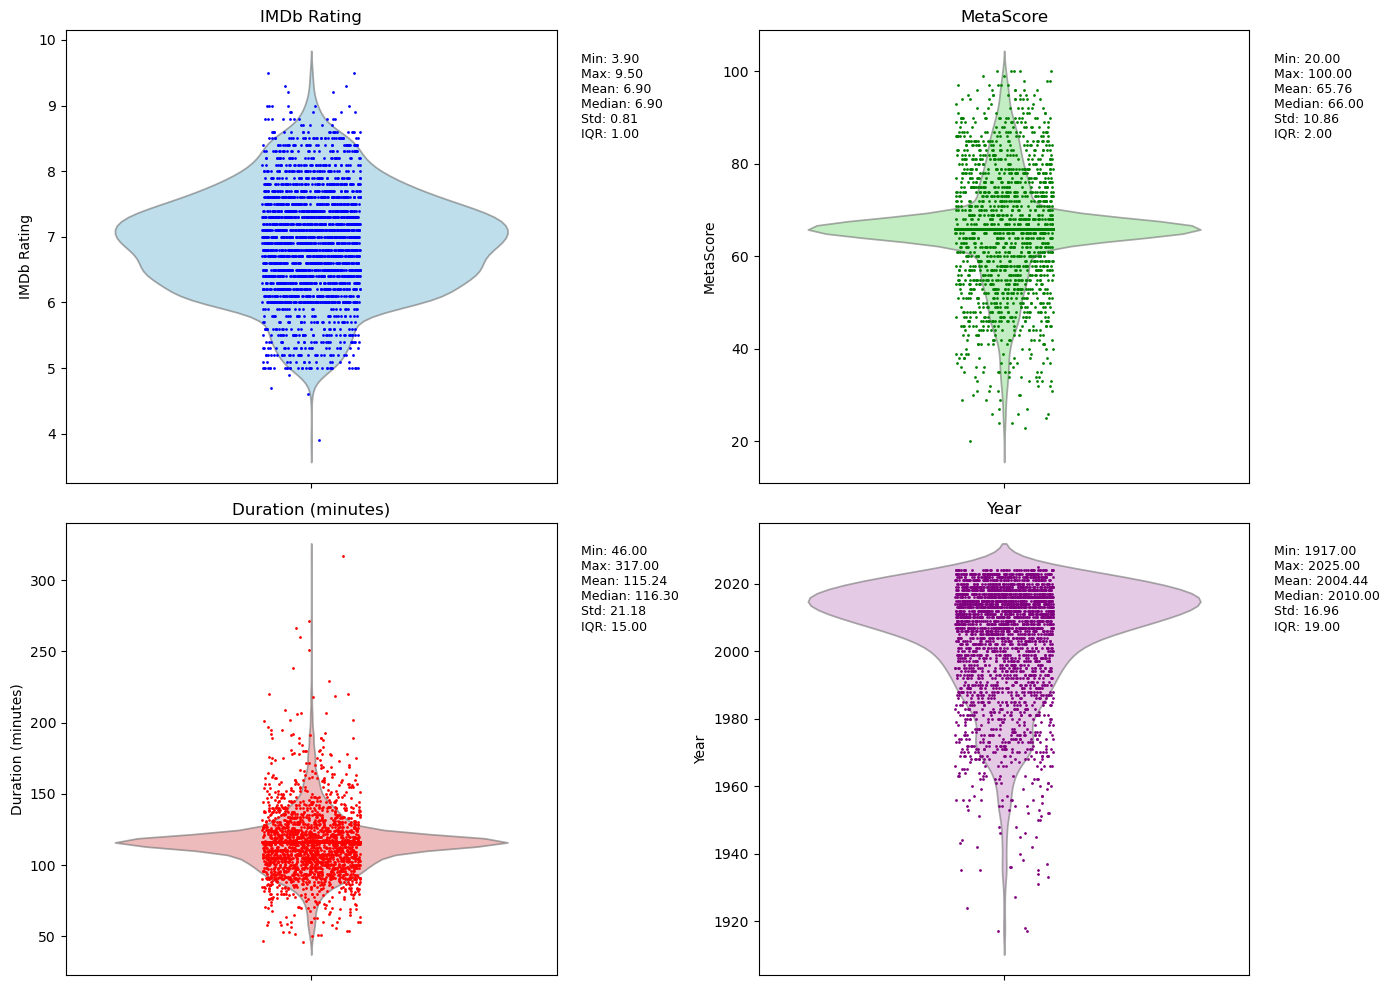

In [43]:
# List of numeric columns to analyze
numeric_columns = ['IMDb Rating', 'MetaScore', 'Duration (minutes)', 'Year']

# Summary statistics
summary = df[numeric_columns].describe().T
summary['IQR'] = summary['75%'] - summary['25%']
print(summary[['count', 'min', '25%', '50%', 'mean', '75%', 'max', 'std', 'IQR']])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

violin_colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
dot_colors = ['blue', 'green', 'red', 'purple']

for idx, col in enumerate(numeric_columns):
    ax = axes[idx]
    data = df[col].dropna()

    # Pick colors for this subplot
    violin_color = violin_colors[idx % len(violin_colors)]
    dot_color = dot_colors[idx % len(dot_colors)]

    # Violin plot with transparent body
    sns.violinplot(y=data, color=violin_color, alpha=0.60, inner=None, ax=ax)

    # Overlay actual data points
    sns.stripplot(y=data, color=dot_color, size=2, jitter=True, ax=ax)

    # Compute stats
    stats = data.describe()
    iqr = stats['75%'] - stats['25%']

    # Place annotation in top-right corner of the subplot
    annotation = (f"Min: {stats['min']:.2f}\n"
                  f"Max: {stats['max']:.2f}\n"
                  f"Mean: {stats['mean']:.2f}\n"
                  f"Median: {stats['50%']:.2f}\n"
                  f"Std: {stats['std']:.2f}\n"
                  f"IQR: {iqr:.2f}")

    ax.text(1.05, 0.95, annotation, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='left')

    ax.set_title(col)

plt.tight_layout()
plt.show()

# **ANALYSIS:**

### We can see that

 ### 1) Movies are rated better in IMDB (6.9/10 median) than in MetaScore overall (66/100 median);
 
 ### 2) Most movies are under 2 hours long;
 
 ### 3) Most movies in the database are relatively modern (mean year 2004, median year 2010)


## 2.3 EDA 3: Statistics for categorical data fields ('Genre', 'Certificates', 'Director', 'Star Cast').

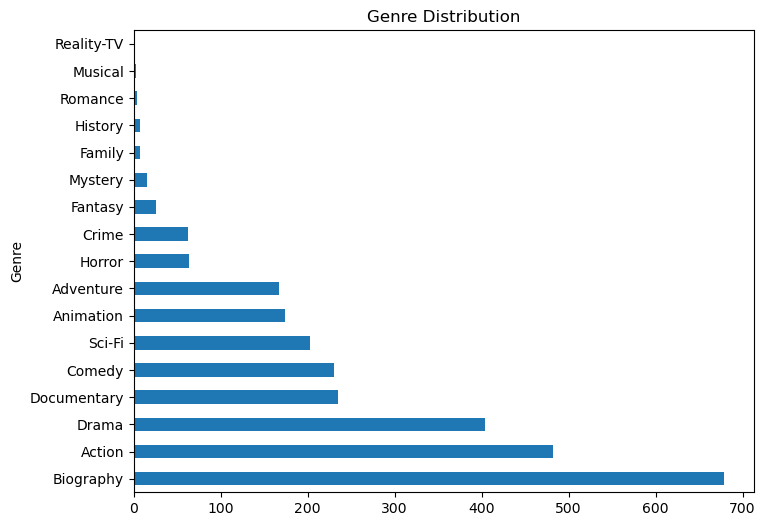

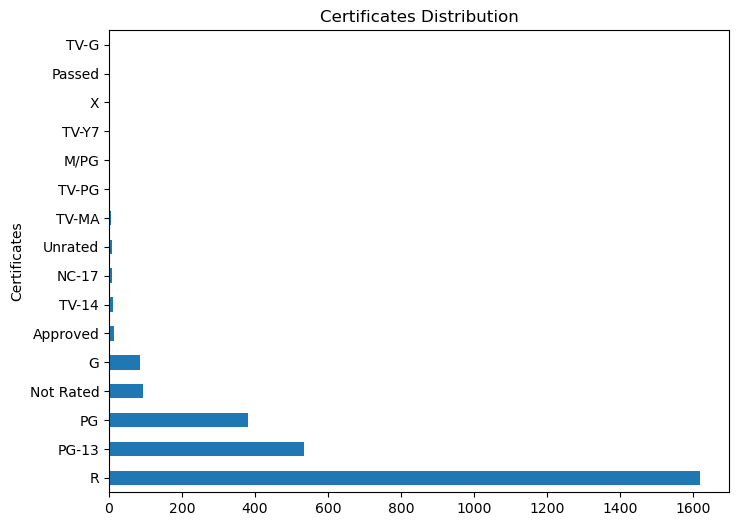

,Top Directors,Director Count,Top Actors,Actor Count
0,Ridley Scott,19,Cast not verified,134
1,Steven Spielberg,14,Tom Hanks,13
2,Martin Scorsese,11,Yoshiyuki Tomino,12
3,Clint Eastwood,10,Caprio,11
4,Tim Burton,9,Leonardo Di,11
5,Oliver Stone,9,Anthony Hopkins,11
6,Ron Howard,8,Daniel Radcliffe,10
7,Christopher Nolan,8,Matt Damon,10
8,David Fincher,7,Woody Harrelson,10
9,George Miller,7,Johnny Depp,9


In [44]:
# Genre frequency count
genre_counts = df['Genre'].value_counts()

# Plot as Pie or Histogram based on number of unique genres
if len(genre_counts) <= 10:
    genre_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6))
else:
    genre_counts.plot.barh(figsize=(8, 6))

plt.title("Genre Distribution")
plt.show()

# Certificates frequency count
certificates_counts = df['Certificates'].value_counts()
if len(certificates_counts) <= 10:
    certificates_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6))
else:
    certificates_counts.plot.barh(figsize=(8, 6))

plt.title("Certificates Distribution")
plt.show()

# Top 10 Directors
top_directors = df['Director'].value_counts().head(10)

# Process Actors
from itertools import chain
actors = df['Star Cast'].dropna().apply(lambda x: [actor.strip() for actor in x.split(',')])
actors_flat = list(chain.from_iterable(actors))
top_actors_series = pd.Series(actors_flat).value_counts().head(10)

# Build a clean DataFrame
summary_table = pd.DataFrame({
    'Top Directors': df['Director'].value_counts().head(10).index,
    'Director Count': df['Director'].value_counts().head(10).values,
    'Top Actors': top_actors_series.index,
    'Actor Count': top_actors_series.values
})

print('\n')
# Ensure Top Actors are formatted as separate names (not mashed together)
summary_table['Top Actors'] = summary_table['Top Actors'].apply(lambda x: str(x))

# Display
from IPython.display import display
display(summary_table)



# **ANALYSIS**
### We can see that
### 1) The Biography genre and R certificate are overrepresented;
### 2) The most represented director is Ridley Scot, while the most represented actor (aside from unverified cast) is Tom Hanks.

In [45]:
# Create movie description for each movie from the details provided in the dataset

def generate_movie_description(row):
    return (
        f"The {row['Year']} {row['Genre']} movie '{row['Title']}', "
        f"directed by {row['Director']} and starring {row['Star Cast']}, "
        f"is rated {row['Certificates']} and runs for {row['Duration (minutes)']} minutes. "
        f"It received a MetaScore of {row['MetaScore']}."
    )

# Add the descriptions to the dataframe as a new column
df['Movie Description'] = df.apply(generate_movie_description, axis=1)

# Print an example to see what the descritions look like
print(df['Movie Description'][1])

The 1967 Biography movie 'Elvira Madigan', directed by Bo Widerberg and starring Pia Degermark, Thommy Berggren, Lennart Malmer, is rated PG and runs for 91.0 minutes. It received a MetaScore of 66.0.


# **3. Chunking, vectorization, and embedding**

In [46]:
# Install these only if not already on your system or environment
# !pip install -U langchain langchain-openai
# !pip install --upgrade langchain langchain-community faiss-cpu


In [47]:
# Create a vector store
# Perform Text Chunking

# 1) build a composite input that concatenates all fields:
def build_embedding_input(row):  # Commented out - blocks "Run All"
    parts = [
        row['Title'],
        row['Genre'],
        row['Director'],
        row['Star Cast'],
        str(row['Year']),
        f"Rated {row['Certificates']}",
        f"Duration {row['Duration (minutes)']} minutes",
        f"MetaScore {row['MetaScore']}"
    ]
    return " | ".join(parts)

df['Embedding Input'] = df.apply(build_embedding_input, axis=1)

# 2) Chunk that “Embedding Input” instead of a plain description:
def simple_chunk(text: str, max_words: int = 50) -> list[str]:
    words = text.split()
    return [
        " ".join(words[i : i + max_words])
        for i in range(0, len(words), max_words)
    ]

df['Description Chunks'] = df['Embedding Input'].apply(
    lambda txt: simple_chunk(txt, max_words=50)
)

# 3) Flatten into a chunk-level DataFrame, carrying all metadata:
chunks = []
for idx, row in df.iterrows():
    for chunk in row['Description Chunks']:
        chunks.append({
            'Title':          row['Title'],
            'Genre':          row['Genre'],
            'Director':       row['Director'],
            'Star Cast':      row['Star Cast'],
            'Year':           row['Year'],
            'Certificates':   row['Certificates'],
            'Duration':       row['Duration (minutes)'],
            'MetaScore':      row['MetaScore'],
            'Chunk':          chunk
        })

chunks_df = pd.DataFrame(chunks)

# Sanity check
print(f"Total chunks: {len(chunks_df)}")
chunks_df.head()


Total chunks: 2762


,Title,Genre,Director,Star Cast,Year,Certificates,Duration,MetaScore,Chunk
0,End of the Spear,Adventure,Jim Hanon,"Louie Leonardo, Chad Allen, Jack Guzman",2005,PG-13,108.0,45.0,End of the Spear | Adventure | Jim Hanon | Lou...
1,Elvira Madigan,Biography,Bo Widerberg,"Pia Degermark, Thommy Berggren, Lennart Malmer",1967,PG,91.0,66.0,Elvira Madigan | Biography | Bo Widerberg | Pi...
2,The Kid Stays in the Picture,Documentary,Nanette Burstein,"Robert Evans, Eddie Albert, Peter Bart",2002,R,93.0,75.0,The Kid Stays in the Picture | Documentary | N...
3,It Ain't Over,Documentary,Sean Mullin,"Andy Andres, Roger Angell, Marty Appel",2022,PG,99.0,79.0,It Ain't Over | Documentary | Sean Mullin | An...
4,Mahler,Biography,Ken Russell,"Robert Powell, Georgina Hale, Lee Montague",1974,PG,115.0,66.0,Mahler | Biography | Ken Russell | Robert Powe...


In [48]:
# Create embeddings for the chunks
# See https://python.langchain.com/docs/integrations/text_embedding/ for a list of available embedding models on LangChain

# Install langchain and langchain-openai if not in the environment already:
# from langchain_openai import OpenAIEmbeddings

from langchain_openai import OpenAIEmbeddings


# 1) Instantiate the LangChain embedding model.
embeddings_model = OpenAIEmbeddings()

# 2) Grab the list of chunk texts straight from the chunk-level DataFrame
chunk_texts = chunks_df["Chunk"].tolist()

# 3) Ask LangChain to embed them all in one call
#    embed_documents returns a List[List[float]]
chunk_embeddings = embeddings_model.embed_documents(chunk_texts)

# 4) Sanity check + attach back to the DataFrame
print(f"Computed {len(chunk_embeddings)} embeddings for {len(chunk_texts)} chunks")

# (optional) store the embeddings in the DataFrame for potential later use
chunks_df["Embedding"] = chunk_embeddings


Computed 2762 embeddings for 2762 chunks


In [49]:
# Create a vector store using the created chunks and the embeddings model
# Install faiss-cpu if not in the environment already:
# pip install -U langchain-community faiss-cpu

from langchain_community.vectorstores import FAISS

# 1) Pull out list of chunk texts & corresponding metadata dicts:
texts     = chunks_df["Chunk"].tolist()
metadatas = chunks_df.drop(columns=["Chunk", "Embedding"]).to_dict("records")

# 2) Build a FAISS store—LangChain will re-embed under the hood via the embeddings_model
vectorstore = FAISS.from_texts(
    texts=texts,
    embedding=embeddings_model,
    metadatas=metadatas
)

# 3) Sanity check: instantiate a retriever for downstream retrieval/QA
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

print(f"FAISS store built with {len(texts)} vectors; retriever ready!")



FAISS store built with 2762 vectors; retriever ready!


# 4. Model selection and processing/implementation


In [50]:
# Create the llm model
# Instantiate the LLM model for response generation

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.0)
print(llm)

# Confirm instantiation
print(f"LLM model instantiated: {llm}")



profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True} client=<openai.resources.chat.completions.completions.Completions object at 0x1af662790> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1bf955410> root_client=<openai.OpenAI object at 0x1af663f90> root_async_client=<openai.AsyncOpenAI object at 0x1af6615d0> model_name='gpt-4.1-mini' temperature=0.0 model_kwargs={} openai_api_key=SecretStr('**********') stream_usage=True
LLM model instantiated: profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 

In [51]:
# This may come in handy further down below
def expand_query(query):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You help clarify movie search queries."},
            {"role": "user", "content": f"Expand and clarify this search query: '{query}'"}
        ]
    )
    return response.choices[0].message.content.strip()


In [52]:
# Create the document processing chain
# NOTE: RetrievalQA is legacy and no longer available in LangChain 1.2+
# We instead build an equivalent retrieval → prompt → LLM chain manually.

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser


# Define a prompt template for retrieval-augmented QA
prompt_template = PromptTemplate.from_template(
    """You are an expert cinematographer and movie assistant. Use the provided
Movie Details to answer queries from users in
a minimalistic, clear, structured, organized but engaging way.
If no relevant movie is found, give a corresponding message.
If an irrelevant or unintelligible query is made, explain that
the query is invalid.

Question: {question}

Context:
{context}

Answer:"""
)

# Confirm creation
print("Prompt template created successfully.")


# Helper: format retrieved documents into a single context string
def _format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)


# Build the retrieval-augmented generation chain
# This replaces RetrievalQA.from_chain_type(...)
qa_chain = (
    {
        "context": retriever | _format_docs,   # retrieve docs and format them
        "question": RunnablePassthrough(),     # pass user question through
    }
    | prompt_template                           # apply the prompt template
    | llm                                      # send to the LLM
    | StrOutputParser()                        # extract the string output
)


# For compatibility with your existing code / debugging expectations
print("QA Chain input keys: ['question']")


Prompt template created successfully.
QA Chain input keys: ['question']


In [53]:
# Create a retriever from the vector store for fetching relevant documents
# See https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/vectorstore/


# Using the FAISS vectorstore created earlier
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# (Optional) Verify that the retriever is ready
print(f"Retriever ready; top-k set to {retriever.search_kwargs.get('k')}")


Retriever ready; top-k set to 5


In [54]:
# Invoke the retrieval chain to process the user's query

def chat_bot(query: str) -> str:
    # pass the query as a dict; RetrievalQA expects an input key of "query"
    # there are multiple ways of doing this... tried all because I was getting
    # a persistent bug in this step....
    #
    # NOTE: RetrievalQA is outdated, so the new qa_chain expects a single
    # string input (the question) and returns a string output.

    out = qa_chain.invoke(query)
    #out = qa_chain.invoke({"question": query})   # also works if you prefer dict form
    #out = qa_chain.run(query)                   # legacy; not applicable for RunnableSequence

    # Return the string output directly (no ["result"] key anymore)
    return out


print(chat_bot("Show me the best movies of all times with mythological creatures."))


Best Movies Featuring Mythological Creatures:

1. **Hercules (1997)**
   - Genre: Animation
   - Director: Ron Clements
   - Key Cast: Ron Clements, John Musker, Don McEnery
   - Rating: G
   - Duration: 93 minutes
   - MetaScore: 74
   - Notes: Classic animated retelling of the Greek demigod Hercules, featuring gods and mythological monsters.

Other listed movies do not prominently feature mythological creatures.

If you want recommendations beyond this list, feel free to ask!


In [55]:
# Perform adequate formatting to print the final response in a user readable format

import textwrap

def format_and_print_response(response: str, width: int = 80):
    """
    Wraps and prints a multi‐line response so that:
      - Prose paragraphs are wrapped at `width` characters
      - Numbered or bulleted lines stay intact
    """
    wrapper = textwrap.TextWrapper(width=width)
    for line in response.split("\n"):
        stripped = line.strip()
        # if this line looks like a numbered or bullet list, don’t re-wrap it
        if stripped.startswith(tuple(f"{i}." for i in range(1,10))) or stripped.startswith(("-", "*")):
            print(line)
        else:
            # wrap long prose lines
            for sub in wrapper.wrap(line):
                print(sub)
    print()  # final blank line for spacing


# Example
user_query = "Show me some end-of the world apocalyptic and dystopian movies."
raw_answer = chat_bot(user_query)

print(f"Movie  Query: {user_query}\n")
format_and_print_response(raw_answer)


Movie  Query: Show me some end-of the world apocalyptic and dystopian movies.

Here are some end-of-the-world apocalyptic and dystopian movies from the list:
1. **Cataclysmo and the Battle for Earth**  
   - Genre: Action  
   - Director: Anthony Parisi  
   - Year: 2008  
   - Rated: R  
   - Duration: 116.3 minutes  
   - MetaScore: 66.0  
2. **Earth Without War**  
   - Genre: Sci-Fi  
   - Director: J. Carlos Portela  
   - Year: 2017  
   - Rated: R  
   - Duration: 116.3 minutes  
   - MetaScore: 66.0  
3. **Slaveworld**  
   - Genre: Sci-Fi  
   - Director: Duane Soebagio  
   - Year: 1995  
   - Rated: R  
   - Duration: 116.3 minutes  
   - MetaScore: 66.0  
4. **The Beginning of the End of the World** (Documentary)  
   - Genre: Documentary  
   - Featuring: Vincent Price  
   - Year: 1971  
   - Rated: R  
   - Duration: 116.3 minutes  
   - MetaScore: 66.0  
If you want more details on any of these, just ask!



#Gradio test to see with a UI if things are working well so far

In [56]:
# If gradio is not installed, you may need to install it with
# !pip install gradio

In [57]:
# Optional: Test the functionality using a Gradio UI (intermediate check)
import gradio as gr

def respond(query: str) -> str:
    """Wrap `chat_bot` so it can be used directly by Gradio."""
    # run the chain
    raw = chat_bot(query)
    # format for readability
    # (you can skip this if you want the raw LLM output)
    return "\n".join(textwrap.fill(line, 80)
                     if not line.lstrip().startswith(tuple(f"{i}." for i in range(1,10)) + ("-","*"))
                     else line
                     for line in raw.split("\n"))

demo = gr.Interface(
    fn=respond,
    inputs=gr.Textbox(lines=2, placeholder="Recommend the best esoteric, mysterious, magical movies of all time.", label="Your Query"),
    outputs=gr.Textbox(lines=8, label="MovieBot Response"),
    title="Movie Search Chatbot",
    description="Ask natural-language questions about movies and get instant, context-aware recommendations."
)

demo.launch(share=False)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


# 5. Use agents and tools

In [58]:
# This helper function will be used by one of the tools below
def search_movies(query: str, top_k: int = 5) -> pd.DataFrame:
    """
    Embed the query using our LangChain OpenAIEmbeddings instance,
    search the FAISS index, and return a clean DataFrame of results.
    """
    # 1) embed with the same model you used to build the index
    query_emb = embeddings_model.embed_query(query)
    qv = np.array(query_emb, dtype="float32").reshape(1, -1)

    # 2) run the FAISS search
    distances, indices = vectorstore.index.search(qv, top_k)

    # 3) pull the matching rows out of the original df
    df_res = df.iloc[indices[0]].reset_index(drop=True)
    return df_res[['Title', 'Genre', 'Director', 'Star Cast']]


In [59]:
# Define various agents - each performing a particular task using tool decorator

from langchain_core.tools import tool
import pandas as pd

import re, random

@tool(
    "Search Movies",
    return_direct=True,
    description="""Extract an optional “top N” from the user’s query,
    run a FAISS similarity search for exactly N results, and format them.
    If zero matches, return an apology."""
)
def search_movies_tool(query: str) -> str:
    #m = re.search(r"\btop\s+(\d+)\b", query, re.IGNORECASE)
    m = re.search(r"\btop\W*(\d+)\b", query, re.IGNORECASE)

    top_k = int(m.group(1)) if m else 3
    df = search_movies(query, top_k=top_k)
    if df.empty:
        return f'Sorry, no relevant movie found for "{query}".'
    lines = [
        f"{i+1}. {row['Title']} (Genre: {row['Genre']}, Director: {row['Director']})"
        for i, row in df.iterrows()
    ]
    return "\n".join(lines)


@tool(
    "Get Movie Details",
    return_direct=True,
    description="Given a movie title, return its director, cast, year, and IMDb rating."
)
def get_movie_details_tool(title: str) -> str:
    matches = df[df["Title"].str.contains(title, case=False)]
    if matches.empty:
        return f'Sorry, I couldn\'t find details for "{title}".'

    r = matches.iloc[0]
    return (
        f"Title: {r.Title}\n"
        f"Year: {r.Year}\n"
        f"Director: {r.Director}\n"
        f"Stars: {r['Star Cast']}\n"
        f"Rating: {r['IMDb Rating']}"
    )

@tool(
    "Trending Movies",
    return_direct=True,
    description="List the current top 3 movies sorted by IMDb rating."
)
def trending_movies_tool(query: str) -> str:

    df_top = df.sort_values("IMDb Rating", ascending=False).head(5)
    lines = [
        f"{i+1}. {row['Title']} ({row['IMDb Rating']})"
        for i, (_, row) in enumerate(df_top.iterrows())
    ]
    return "\n".join(lines)


@tool(
    "Summarize Recommendations",
    return_direct=True,
    description="Given a list of movie titles, write a 2-sentence overview on why these are good picks."
)
def summarize_recommendations_tool(titles: str) -> str:
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful movie recommendation assistant."},
                {"role": "user", "content": f"Here are some movie recommendations:\n{titles}\nWrite a brief (2-sentence) overview of why these are great choices."}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Summarization error: {e}")
        return f"I can't summarize these recommendations right now. The titles provided were: {titles}"

@tool(
    "Movie Quiz",
    return_direct=True,
    description="Generate one multiple-choice trivia question about a random movie and reveal the answer."
)
def quiz_tool(query: str) -> str:
    row = df.sample(1).iloc[0]
    correct = int(row.Year)
    opts = {correct}
    while len(opts) < 4:
        opts.add(random.randint(correct-10, correct+10))
    opts = list(opts)
    random.shuffle(opts)

    # Find the position of the correct answer
    correct_index = opts.index(correct)

    question = f"What year was \"{row.Title}\" released?"
    choices = "\n".join(f"{i+1}. {y}" for i,y in enumerate(opts))
    answer = f"\nThe correct answer is {correct_index + 1}. {correct} - '{row.Title}' was released in {correct}."

    return f"{question}\n{choices}{answer}"




In [60]:
print(trending_movies_tool.invoke(""))



1. The People's Story (9.5)
2. Marty's Project (9.5)
3. Loving Carmen (9.3)
4. The Shawshank Redemption (9.3)
5. Fuga dalla Morte (9.2)


In [61]:
# A simple name→function lookup for explicit dispatch of the correct tool
tool_map = {
    "Search Movies":              search_movies_tool,
    "Get Movie Details":          get_movie_details_tool,
    "Summarize Recommendations":  summarize_recommendations_tool,
    "Trending Movies":            trending_movies_tool,
    "Movie Quiz":                 quiz_tool,
}

# Orchestrator

In [62]:
# Define the orchestrator logic to run the agents appropriately
from langchain.agents import create_agent as create_react_agent

agent_tools = [
    search_movies_tool,
    get_movie_details_tool,
    summarize_recommendations_tool,
    trending_movies_tool,
    quiz_tool
]

# provide a short prefix so the agent knows which tool does what
prefix = """
You are MovieBot, and you have these tools:

• Search Movies(query: str) → returns exactly N matches for any “find me” or “recommend me” style question.
  Example: “Top 3 vampire movies” → Search Movies(“Top 3 vampire movies”).

• Get Movie Details(title: str) → returns year, director, cast & rating for a single movie title.
  Example: “Tell me about Inception” → Get Movie Details(“Inception”).

• Summarize Recommendations(titles: str) → when given a list of titles, returns a 2-sentence overview.
  Example: “Why these 3 sci-fi picks?” → Summarize Recommendations(“1. …\n2. …\n3. …”).

• Trending Movies(dummy: str) → returns the current top 5 movies by rating.
  Example: “What’s trending right now?” → Trending Movies("").

• Movie Quiz(dummy: str) → returns one multiple-choice trivia question.
  Example: “Surprise me with a quiz” → Movie Quiz("").

Always pick the tool whose description best matches the user’s request. Do not hand-roll lists yourself.
"""

#orchestrator = initialize_agent(
#    tools=agent_tools,
#    llm=llm,
#    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
#    agent_kwargs={"prefix": prefix},
#    verbose=True
#)

#orchestrator = create_react_agent(llm, tools=agent_tools, system_message=prefix)
#orchestrator = create_react_agent(llm, tools=agent_tools, prompt=prefix)
orchestrator = create_react_agent(llm, tools=agent_tools, system_prompt=prefix)


print("Orchestrator agent initialized successfully.")


Orchestrator agent initialized successfully.


# Google Drive Integration & Storing Historical Conversations



# Save the history of the query conversations

In [63]:
import os, json
from datetime import datetime

from langchain_core.messages import HumanMessage
import traceback


# MOVIE_BOT_DIR was already defined above at the very beginning of the notebook
#MOVIE_BOT_DIR = '/content/sample_data/'
os.makedirs(MOVIE_BOT_DIR, exist_ok=True)
LOG_PATH = os.path.join(MOVIE_BOT_DIR, 'chat_history.json')

def load_history_json():
    if os.path.exists(LOG_PATH):
        try:
            with open(LOG_PATH, 'r') as f:
                return json.load(f)
        except (json.JSONDecodeError, FileNotFoundError):
            # Handle empty or invalid file
            return [{"role":"system","content":"You are a helpful movie-bot."}]
    else:
        # Create the file with initial content if it doesn't exist
        initial_content = [{"role":"system","content":"You are a helpful movie-bot."}]
        with open(LOG_PATH, 'w') as f:
            json.dump(initial_content, f, indent=2)
        return initial_content

def save_history_json(h):
    try:
        with open(LOG_PATH, "w") as f:
            json.dump(h, f, indent=2)
    except Exception as e:
        print(f"Error saving history: {e}")




# quick check
print("tool_map is defined?", 'tool_map' in globals(), tool_map.keys() if 'tool_map' in globals() else None)


def respond_with_history(tool_name, user_query, history):
    q = (user_query or "").strip()
    if not q:
        reply = 'Please enter a movie question, e.g. "Show me top-rated alien movies."'
        history.append({"role": "user", "content": q})
        history.append({"role": "assistant", "content": reply})
        return history, history

    # Map dropdown choice -> tool object
    tool_map = {
        "Search Movies": search_movies_tool,
        "Get Movie Details": get_movie_details_tool,
        "Summarize Recommendations": summarize_recommendations_tool,
        "Trending Movies": trending_movies_tool,
        "Movie Quiz": quiz_tool,
    }

    try:
        if tool_name:
            tool_obj = tool_map[tool_name]

            # Prefer .invoke if available (newer LC tools), fall back to calling it directly
            if hasattr(tool_obj, "invoke"):
                try:
                    tool_out = tool_obj.invoke(q)  # many tools accept a plain string
                except TypeError:
                    # if it expects a dict, try common key names
                    for key in ("query", "title", "titles", "text", "input"):
                        try:
                            tool_out = tool_obj.invoke({key: q})
                            break
                        except TypeError:
                            continue
                    else:
                        raise
            else:
                tool_out = tool_obj(q)

            reply = tool_out if isinstance(tool_out, str) else str(tool_out)

        else:
                reply = "Please select a tool from the dropdown."
    except Exception as e:
        reply = f"ERROR: {type(e).__name__}: {e}"

        # Log full traceback so you can actually debug
        ts = datetime.now().isoformat()
        with open(LOG_PATH, "a") as f:
            f.write(f"{ts}\tEXCEPTION in respond_with_history\n")
            f.write(traceback.format_exc())
            f.write("\n\n")

    # append to history + log
    history.append({"role": "user", "content": q})
    history.append({"role": "assistant", "content": reply})

    ts = datetime.now().isoformat()
    with open(LOG_PATH, "a") as f:
        f.write(f"{ts}\tUSER [{tool_name}]: {q}\n")
        f.write(f"{ts}\tBOT               : {reply}\n\n")

    return history, history



tool_map is defined? True dict_keys(['Search Movies', 'Get Movie Details', 'Summarize Recommendations', 'Trending Movies', 'Movie Quiz'])


In [64]:
# Check the edge cases and handle them appropriately
# Including the logging function in each call to the "safe" agent

# Edge-case handling: validate input & catch runtime errors
from datetime import datetime

def run_agent_safe(query: str) -> str:
    """
    1) Reject blank queries
    2) Gate gibberish via RetrievalQA (chat_bot)
    3) Forward valid queries to the multi‐tool orchestrator
    4) Log every turn to LOG_PATH, but never let logging errors bubble out
    """
    q = query.strip()
    if not q:
        return 'Please enter a movie question, for example: "Show me top-rated alien movies of all time."'

    # 1) Gibberish gate
    try:
        gate = chat_bot(q)
    except Exception:
        gate = ""  # if chat_bot itself fails, we'll treat as non-gibberish

    low = gate.lower()
    if any(kw in low for kw in ("don’t recognize", "sorry", "invalid", "no matches")):
        reply = gate
    else:
        # 2) Valid: call the orchestrator
        try:
            reply = orchestrator.run(q)
        except Exception:
            reply = "Sorry, something went wrong. Could you try rephrasing your question?"

    # 3) Logging (never raise)
    try:
        ts = datetime.now().isoformat()
        with open(LOG_PATH, "a") as f:
            f.write(f"{ts}\tUSER: {q}\n")
            f.write(f"{ts}\tBOT : {reply}\n\n")
    except Exception:
        pass

    return reply




In [65]:
# Create a simple Gradio UI for the movie‐search chatbot
import gradio as gr
import re
from datetime import datetime
from langchain_core.messages import HumanMessage

# 1) Define your Dropdown *before* the demo:
TOOL_CHOICES = [
    "Search Movies",
    "Get Movie Details",
    "Summarize Recommendations",
    "Trending Movies",
    "Movie Quiz",
]

with gr.Blocks() as demo:
    gr.Markdown(
        "## Movie Search Chatbot\n"
        "Pick a tool or let the agent auto-choose, then enter your query."
    )

    # --- tool selector + text input + submit button ---
    with gr.Row():
        tool_sel = gr.Dropdown(
            choices=TOOL_CHOICES,
            label="Use Tool",
            interactive=True,
        )
        txt = gr.Textbox(
            placeholder="e.g. Top 3 vampire movies, or ‘The Matrix’ for details…",
            label="Your Query",
            lines=2,
        )
        btn = gr.Button("Submit", variant="primary")

    # --- chat history UI + state ---
    chatbot = gr.Chatbot(label="Conversation")


    state   = gr.State([])

    # 2) callback needs tool_sel + txt + state

    
    def respond_with_history(tool_name, user_query, history):
        q = (user_query or "").strip()

        # Map dropdown choice -> tool object
        tool_map = {
            "Search Movies": search_movies_tool,
            "Get Movie Details": get_movie_details_tool,
            "Summarize Recommendations": summarize_recommendations_tool,
            "Trending Movies": trending_movies_tool,
            "Movie Quiz": quiz_tool,
        }

        if not q:
            reply = 'Please enter a movie question, e.g. "Show me top-rated alien movies."'
        else:
            try:
                # If user picks a tool explicitly, call the tool directly (do NOT route through the agent)
                if tool_name:
                    tool_obj = tool_map[tool_name]

                    # Prefer .invoke() for @tool-wrapped tools
                    if hasattr(tool_obj, "invoke"):
                        try:
                            out = tool_obj.invoke(q)
                        except TypeError:
                            # Some tools may expect a dict input schema; try common keys
                            out = None
                            for key in ("query", "title", "titles", "input", "text"):
                                try:
                                    out = tool_obj.invoke({key: q})
                                    break
                                except TypeError:
                                    continue
                            if out is None:
                                raise
                    else:
                        out = tool_obj(q)

                    reply = out if isinstance(out, str) else str(out)

                else:
                    reply = "Please select a tool from the dropdown."
            except Exception as e:
                reply = f"ERROR: {type(e).__name__}: {e}"

        # append to history + log
        history.append({"role": "user", "content": q})
        history.append({"role": "assistant", "content": reply})

        ts = datetime.now().isoformat()
        with open(LOG_PATH, "a") as f:
            f.write(f"{ts}\tUSER [{tool_name}]: {q}\n")
            f.write(f"{ts}\tBOT               : {reply}\n\n")

        return history, history


    # 3) wire up both click and enter-key
    btn.click(
        fn=respond_with_history,
        inputs=[tool_sel, txt, state],
        outputs=[chatbot, state],
    )
    txt.submit(
        fn=respond_with_history,
        inputs=[tool_sel, txt, state],
        outputs=[chatbot, state],
    )

demo.launch(share=False)



* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# Sanity checks/tests

In [66]:
import os, traceback

print("OPENAI_API_KEY present?", bool(os.environ.get("OPENAI_API_KEY")))
print("OPENAI_API_KEY prefix:", (os.environ.get("OPENAI_API_KEY") or "")[:8])

def _try(label, fn):
    print("\n===", label, "===")
    try:
        out = fn()
        print("OK:", (out if isinstance(out, str) else str(out))[:400])
        return out
    except Exception as e:
        print("ERROR:", type(e).__name__, e)
        print(traceback.format_exc())
        raise

# 1) Test each tool directly (no agent)
_try("search_movies_tool('vampire movies')", lambda: search_movies_tool.invoke("vampire movies") if hasattr(search_movies_tool, "invoke") else search_movies_tool("vampire movies"))
_try("get_movie_details_tool('The Matrix')", lambda: get_movie_details_tool.invoke("The Matrix") if hasattr(get_movie_details_tool, "invoke") else get_movie_details_tool("The Matrix"))
_try("trending_movies_tool('')", lambda: trending_movies_tool.invoke("") if hasattr(trending_movies_tool, "invoke") else trending_movies_tool(""))


OPENAI_API_KEY present? True
OPENAI_API_KEY prefix: sk-proj-

=== search_movies_tool('vampire movies') ===
OK: 1. Interview with the Vampire: The Vampire Chronicles (Genre: Drama, Director: Neil Jordan)
2. Nosferatu (Genre: Fantasy, Director: Robert Eggers)
3. Lamp the Movie (That Really Shouldn't Exist); *A Dracula Film (Genre: Comedy, Director: Lenwood S. Sharpe)

=== get_movie_details_tool('The Matrix') ===
OK: Title: Rifftrax: The Matrix
Year: 2006
Director: Kevin Murphy
Stars: Cast not verified
Rating: 7.6

=== trending_movies_tool('') ===
OK: 1. The People's Story (9.5)
2. Marty's Project (9.5)
3. Loving Carmen (9.3)
4. The Shawshank Redemption (9.3)
5. Fuga dalla Morte (9.2)


"1. The People's Story (9.5)\n2. Marty's Project (9.5)\n3. Loving Carmen (9.3)\n4. The Shawshank Redemption (9.3)\n5. Fuga dalla Morte (9.2)"

# Check that the history log file is indeed saved

In [67]:
# This cell is for Google Colab only - checking chat history file
# Uncomment and run manually if using Colab:
#
#   # Check if file exists
#   !ls -la /content/sample_data/chat_history.json
#
#   # View file contents
#   !cat /content/sample_data/chat_history.json

# **6. Evaluation & Future Work Suggestions**

#Possible Future Performance Analyses to conduct
  * Measure retrieval speed.
  * User satisfaction ratings (assuming I deployed this chatbot for public use somewhere online)
  * Log search result accuracy (this would require defining a metric and establishing a ground-truth baseline though...).

#Possible Future Improvements
  * Add multimodal inputs (image + text).
  * Show the posters with wach movie recommendation (we do have the URLs in the database...).
  * Increased use of agentic AI to handle multi-turn, context-aware conversations.
